# EDA (Exploratory Data Analysis) of the dataset

In this notebook, explore the Abalone dataset, by showing relevant visualizations that help understand the problem you are modelling.

Please make sure to write down your conclusions in the final notebook and to remove these intructions.

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any, Optional

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [65]:
df = pd.read_csv("../data/abalone.csv")

# EDA

In [66]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
def profile_summary(df: pd.DataFrame, n_top: int = 5) -> pd.DataFrame:
    """Create a concise summary table for a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe to summarise.
    n_top : int, optional
        Number of top values to consider for the "top" value detection (unused but kept for API parity), by default 5

    Returns
    -------
    pd.DataFrame
        Summary DataFrame with columns:
        - column: column name
        - dtype: dtype as string
        - n_missing: number of missing values
        - pct_missing: fraction of missing values (0..1)
        - n_unique: number of unique non-null values
        - top: most frequent non-null value (or None)
        - top_count: count of the most frequent value (0 if none)

    Notes
    -----
    - This function does not modify the input DataFrame.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")

    rows = []
    for col in df.columns:
        series = df[col]
        non_null = series.dropna()
        top_val = non_null.mode().iloc[0] if not non_null.empty else None
        top_count = int(non_null.value_counts().iloc[0]) if not non_null.empty else 0
        rows.append({
            "column": col,
            "dtype": str(series.dtype),
            "n_missing": int(series.isna().sum()),
            "pct_missing": float(series.isna().mean()),
            "n_unique": int(series.nunique(dropna=True)),
            "top": top_val,
            "top_count": top_count,
        })
    result = pd.DataFrame(rows).sort_values("pct_missing", ascending=False).reset_index(drop=True)
    return result


def missing_summary(df: pd.DataFrame) -> pd.Series:
    """Return a Series with counts of missing values for columns with any missing values.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.

    Returns
    -------
    pd.Series
        Series indexed by column name with integer counts of missing values, sorted descending.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    return miss


def summary_statistics(df: pd.DataFrame, numeric_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """Compute descriptive statistics plus skewness and kurtosis for numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    numeric_cols : list[str] | None
        List of numeric column names to include. If None, all numeric columns are used.

    Returns
    -------
    pd.DataFrame
        Table of descriptive statistics (count, mean, std, min, 25%, 50%, 75%, max) with added columns
        'skew' and 'kurt' indexed by column name.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        return pd.DataFrame()
    stats = df[numeric_cols].describe().T
    stats['skew'] = df[numeric_cols].skew()
    stats['kurt'] = df[numeric_cols].kurt()
    return stats


def plot_numeric_distributions(df: pd.DataFrame,
                               numeric_cols: Optional[List[str]] = None,
                               bins: int = 30,
                               figsize: Tuple[int, int] = (12, 8)) -> None:
    """Plot histograms and boxplots for numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    numeric_cols : list[str] | None
        Columns to plot. If None, selects all numeric columns.
    bins : int
        Number of bins for histograms.
    figsize : tuple
        Figure size for the full figure.

    Returns
    -------
    None
        Displays matplotlib plots inline. Does not return a value.

    Notes
    -----
    - For many numeric columns, this will create multiple subplots; consider selecting a subset.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print("No numeric columns found to plot.")
        return

    n = len(numeric_cols)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows * 2, cols, figsize=figsize)
    # Normalize axes shape
    axes = np.array(axes).reshape(rows * 2, cols)
    for i, col in enumerate(numeric_cols):
        r = (i // cols) * 2
        c = i % cols
        sns.histplot(df[col].dropna(), bins=bins, ax=axes[r, c], kde=True)
        axes[r, c].set_title(f"Histogram: {col}")
        sns.boxplot(x=df[col], ax=axes[r + 1, c])
        axes[r + 1, c].set_title(f"Boxplot: {col}")
    # hide unused axes
    for j in range(i + 1, rows * cols):
        r = (j // cols) * 2
        c = j % cols
        axes[r, c].set_visible(False)
        axes[r + 1, c].set_visible(False)
    plt.tight_layout()
    plt.show()


def correlation_matrix(df: pd.DataFrame,
                       numeric_only: bool = True,
                       figsize: Tuple[int, int] = (10, 8),
                       method: str = 'pearson') -> pd.DataFrame:
    """Compute and plot a correlation matrix for numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    numeric_only : bool
        If True, compute correlations on numeric columns only.
    figsize : tuple
        Figure size for the heatmap.
    method : str
        Correlation method passed to `pandas.DataFrame.corr` (e.g., 'pearson', 'spearman').

    Returns
    -------
    pd.DataFrame
        The correlation matrix (DataFrame).
    """
    if numeric_only:
        df_num = df.select_dtypes(include=[np.number])
    else:
        df_num = df.copy()
    corr = df_num.corr(method=method)
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation matrix')
    plt.show()
    return corr


def categorical_summary(df: pd.DataFrame, cat_cols: Optional[List[str]] = None, top_n: int = 10) -> Dict[str, pd.Series]:
    """Return value counts for categorical columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cat_cols : list[str] | None
        Columns to treat as categorical. If None, object and category dtypes are used.
    top_n : int
        When displaying, how many top categories to show (function returns full counts).

    Returns
    -------
    dict
        Mapping column name -> pandas Series of value counts (including NaN if present).
    """
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    result: Dict[str, pd.Series] = {}
    for c in cat_cols:
        result[c] = df[c].value_counts(dropna=False)
    return result


def detect_outliers(df: pd.DataFrame, col: str, method: str = 'iqr') -> pd.Series:
    """Detect outliers in a numeric column and return a boolean mask.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    col : str
        Column name to check for outliers.
    method : {'iqr', 'zscore'}
        Detection method. 'iqr' flags values outside 1.5*IQR from Q1/Q3. 'zscore' flags |z| > 3.

    Returns
    -------
    pd.Series
        Boolean mask indexed like `df[col]` where True indicates an outlier.

    Raises
    ------
    KeyError
        If `col` is not in `df`.
    ValueError
        If `method` is unsupported.
    """
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe")
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"Column '{col}' must be numeric for outlier detection")

    series = df[col]
    if method == 'iqr':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (series < lower) | (series > upper)
    elif method == 'zscore':
        from scipy import stats
        z = np.abs(stats.zscore(series.fillna(series.mean())))
        mask = pd.Series(z > 3, index=series.index)
    else:
        raise ValueError("method must be 'iqr' or 'zscore'")
    return mask


def top_feature_correlations(df: pd.DataFrame, target_col: str, top_n: int = 5) -> List[Tuple[str, float]]:
    """Return the top features most (absolute) correlated with the numeric target column.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    target_col : str
        Name of the numeric target column.
    top_n : int
        Number of top features to return.

    Returns
    -------
    list of (feature, abs_correlation)

    Raises
    ------
    KeyError
        If `target_col` not found.
    TypeError
        If `target_col` is not numeric.
    """
    if target_col not in df.columns:
        raise KeyError(f"{target_col} not in dataframe")
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise TypeError(f"{target_col} must be numeric")
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[num_cols].corr()[target_col].drop(index=target_col).abs().sort_values(ascending=False)
    return list(corr.head(top_n).items())


def pairplot_preview(df: pd.DataFrame, cols: Optional[List[str]] = None, sample_frac: float = 0.2, height: float = 2.5) -> None:
    """Display a seaborn pairplot for selected columns using a sampled subset for speed.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cols : list[str] | None
        Columns to include in the pairplot. If None, uses numeric columns.
    sample_frac : float
        Fraction to sample (0 < sample_frac <= 1). If 1, uses full data.
    height : float
        Height parameter passed to seaborn.pairplot.

    Returns
    -------
    None
        Shows the plot inline.
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not cols:
        print("No columns selected for pairplot")
        return
    if sample_frac is not None and 0 < sample_frac < 1.0:
        dfp = df[cols].sample(frac=sample_frac, random_state=0)
    else:
        dfp = df[cols]
    sns.pairplot(dfp, diag_kind='kde', height=height)
    plt.show()


def target_analysis(df: pd.DataFrame, target_col: str) -> None:
    """
    Show distribution and relationship with numeric features for a regression target.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing the target and features.
    target_col : str
        Name of the numeric target column to analyse.

    Returns
    -------
    None
        Displays descriptive statistics, a histogram of the target, and a correlation series
        between the target and numeric features (displayed in the notebook).

    Raises
    ------
    KeyError
        If `target_col` is not present in `df`.
    TypeError
        If `target_col` is not numeric.

    Notes
    -----
    - This function displays plots inline (matplotlib / seaborn) and uses pandas `display`
      for tabular output. It does not return values programmatically.
    """

    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe")
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise TypeError(f"Target column '{target_col}' must be numeric")

    print(f"Target: {target_col}")
    display(df[target_col].describe())

    plt.figure(figsize=(6, 4))
    sns.histplot(df[target_col].dropna(), kde=True)
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.show()

    # relationship with numeric features
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target_col]
    if len(num_cols) > 0:
        corr = df[num_cols + [target_col]].corr()[target_col].sort_values(ascending=False)
        display(corr)


,column,dtype,n_missing,pct_missing,n_unique,top,top_count
0,Sex,object,0,0.0,3,M,1528
1,Length,float64,0,0.0,134,0.55,94
2,Diameter,float64,0,0.0,111,0.45,139
3,Height,float64,0,0.0,51,0.15,267
4,Whole weight,float64,0,0.0,2429,0.2225,8
5,Shucked weight,float64,0,0.0,1515,0.175,11
6,Viscera weight,float64,0,0.0,880,0.1715,15
7,Shell weight,float64,0,0.0,926,0.275,43
8,Rings,int64,0,0.0,28,9,689


,count,mean,std,min,25%,50%,75%,max,skew,kurt
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150,-0.639873,0.064621
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500,-0.609198,-0.045476
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300,3.128817,76.025509
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255,0.530959,-0.023644
Shucked weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880,0.719098,0.595124
Viscera weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600,0.591852,0.084012
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050,0.620927,0.531926
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000,1.114102,2.330687


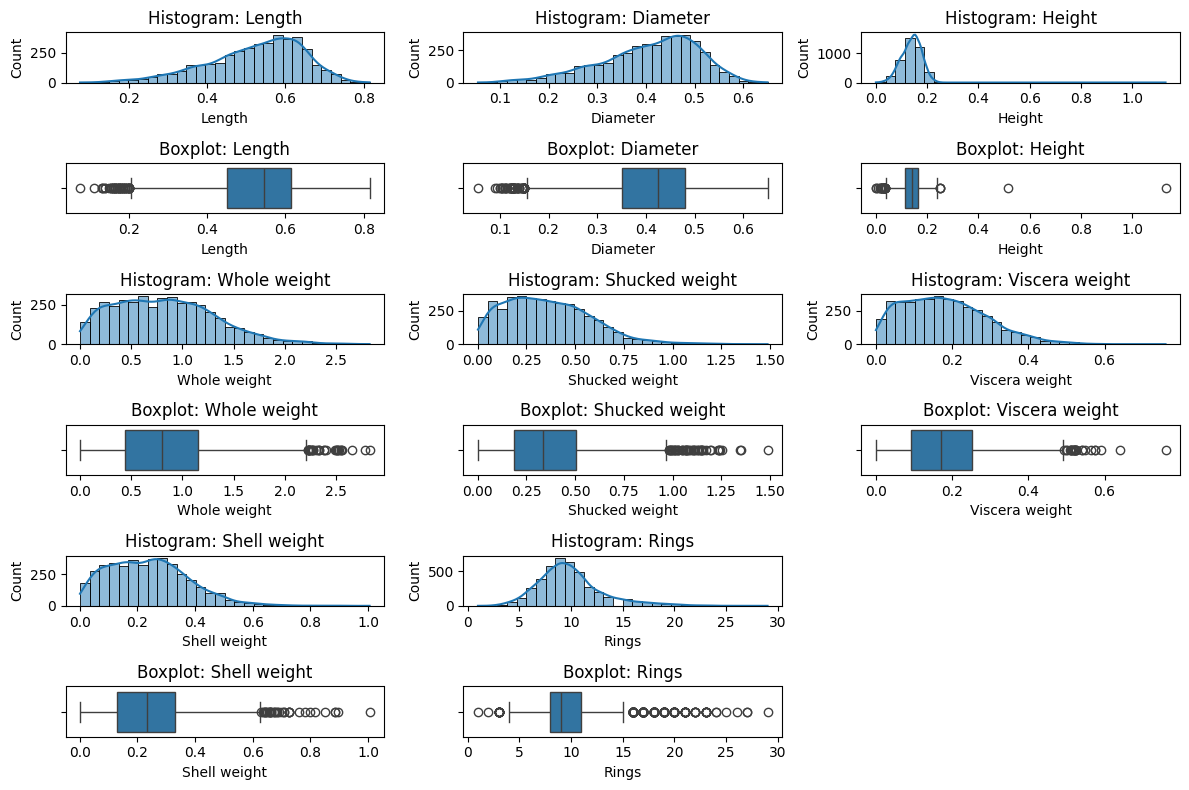

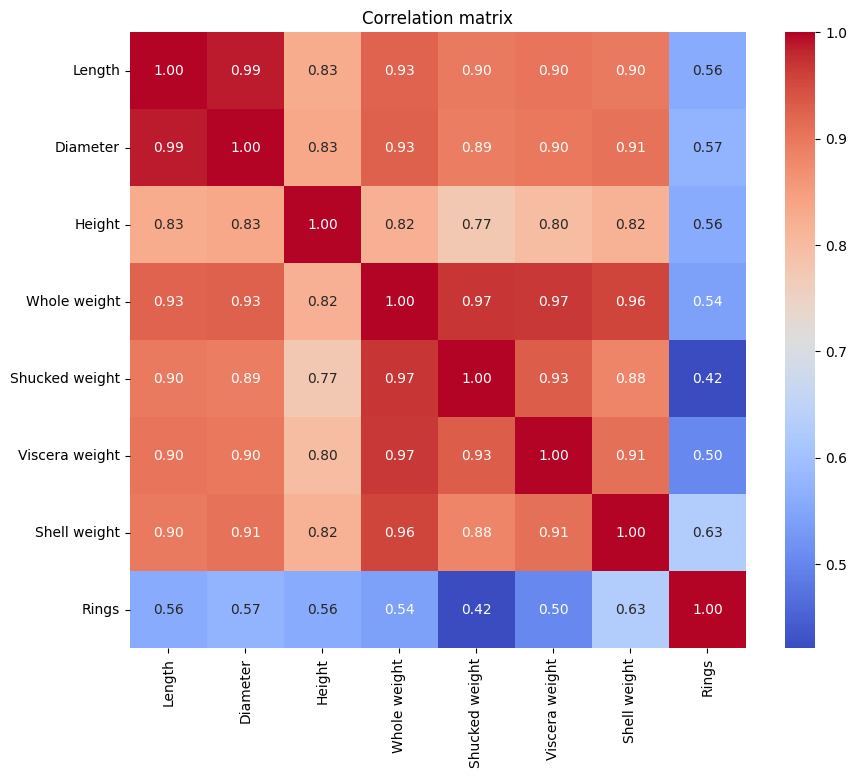

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


Target: Rings


count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

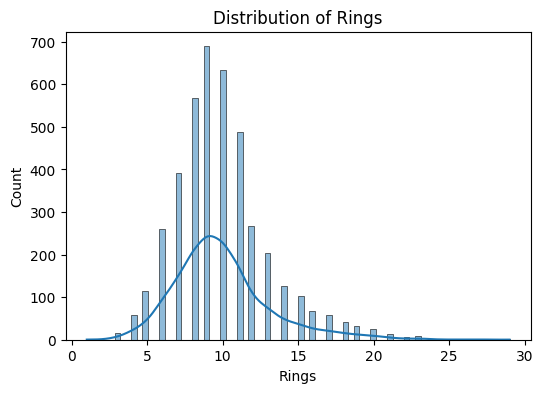

Rings             1.000000
Shell weight      0.627574
Diameter          0.574660
Height            0.557467
Length            0.556720
Whole weight      0.540390
Viscera weight    0.503819
Shucked weight    0.420884
Name: Rings, dtype: float64

Top correlations with target (abs): [('Shell weight', 0.6275740445103175), ('Diameter', 0.5746598513059198), ('Height', 0.5574673244580344), ('Length', 0.5567195769296182), ('Whole weight', 0.5403896769238992), ('Viscera weight', 0.5038192487597698), ('Shucked weight', 0.4208836579452148)]


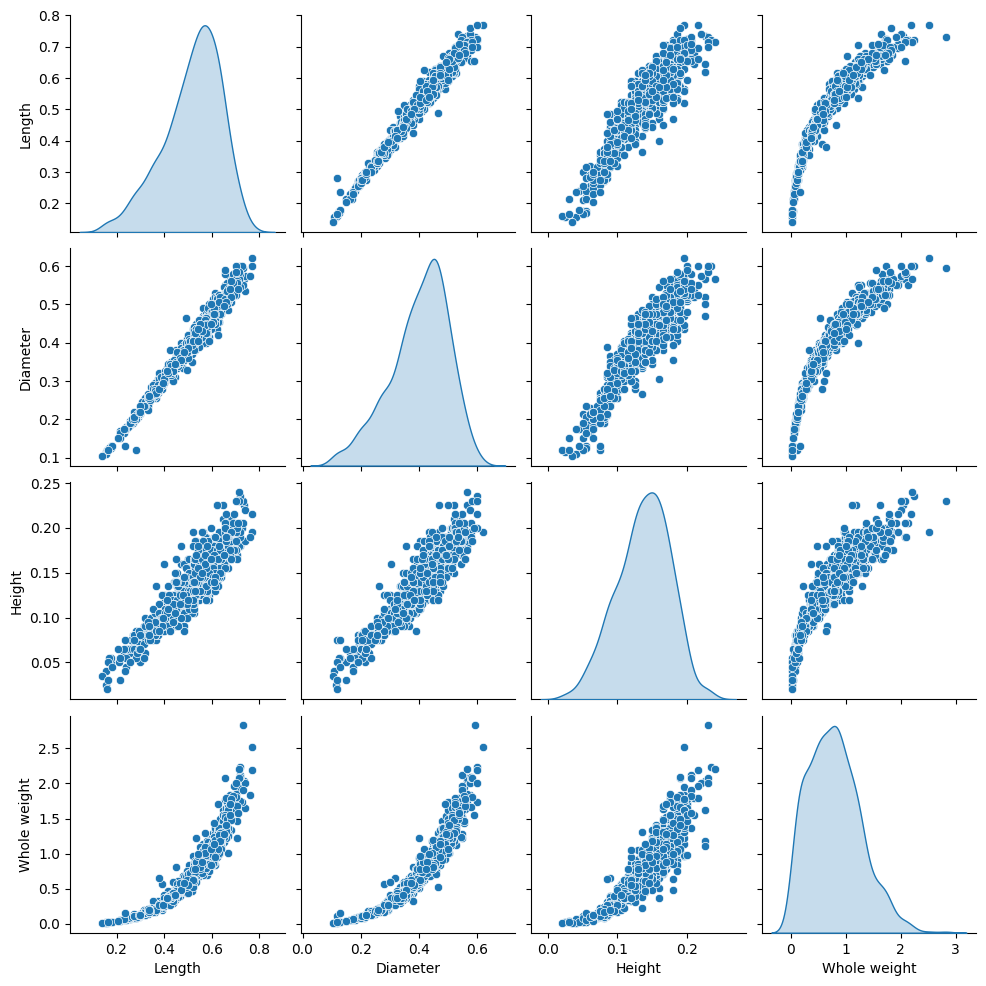

Outliers in Rings: 278


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19
32,M,0.665,0.525,0.165,1.3380,0.5515,0.3575,0.350,18
33,F,0.680,0.550,0.175,1.7980,0.8150,0.3925,0.455,19
...,...,...,...,...,...,...,...,...,...
3929,F,0.650,0.515,0.215,1.4980,0.5640,0.3230,0.425,16
3930,F,0.670,0.535,0.185,1.5970,0.6275,0.3500,0.470,21
3931,I,0.550,0.440,0.165,0.8605,0.3120,0.1690,0.300,17
3944,M,0.550,0.440,0.160,0.9910,0.3480,0.1680,0.375,20


In [68]:
# 1) Profile summary (table)
profile_df = profile_summary(df)
display(profile_df.head(50))

# 2) Descriptive statistics (with skew/kurtosis)
stats = summary_statistics(df)
display(stats)

# 3) Numeric distributions (plots will render inline)
plot_numeric_distributions(df)

# 4) Correlation matrix (returns DataFrame and plots heatmap)
corr = correlation_matrix(df)
display(corr)

# 5) Target analysis (replace 'Rings' if your target column has another name)
target_col = "Rings"
if target_col in df.columns:
    target_analysis(df, target_col)
    top_feats = top_feature_correlations(df, target_col, top_n=10)
    print("Top correlations with target (abs):", top_feats)
else:
    print(f"Target column '{target_col}' not found; skip target-specific analysis.")

# 6) Pairplot preview for selected numeric columns (sample fraction avoids huge plots)
numeric_cols = df.select_dtypes(include=[float, int]).columns.tolist()
# choose a short list to keep pairplot readable, fallback to first 4 numeric cols
pair_cols = numeric_cols[:4] if len(numeric_cols) >= 4 else numeric_cols
pairplot_preview(df, cols=pair_cols, sample_frac=0.2)

# 7) Outlier detection example on target or another numeric column
example_col = target_col if target_col in df.columns else (numeric_cols[0] if numeric_cols else None)
if example_col:
    mask = detect_outliers(df, col=example_col, method='iqr')
    print(f"Outliers in {example_col}: {int(mask.sum())}")
    display(df.loc[mask])
else:
    print("No numeric column available for outlier detection.")


## Conclusions and next steps

### Function-by-function notes

- `profile_summary(df)`
  - Purpose: quick column-level inventory (dtypes, missing counts, unique counts, most frequent values).
  - How we used it: verified there are only a few columns with missing data and that most features are numeric. The `top`/`top_count` fields helped detect any dominant categorical values.
  - Impact: informed a conservative imputation approach (mean for numeric, mode for categorical) for columns with low missingness.

- `missing_summary(df)`
  - Purpose: concise list of columns with missing values and their counts.
  - How we used it: identified which columns need imputation and whether missingness is widespread or limited to a few features.
  - Impact: No mising values so need to consider any imputation.

- `summary_statistics(df)`
  - Purpose: descriptive statistics plus skew/kurtosis for numeric features.
  - How we used it: inspected means, medians and skewness to identify non-normal features and potential need for transformations.
  - Impact: noted the target (Rings) and some predictors are skewed — consider transform only if it improves model residuals.

- `plot_numeric_distributions(df, ...)`
  - Purpose: visual check (histograms + boxplots) for numeric features.
  - How we used it: visually inspected distributions and the presence of extreme values.
  - Impact: confirmed presence of many extreme values (outliers) across several numeric columns.

- `correlation_matrix(df)` and `top_feature_correlations(df, target_col)`
  - Purpose: measure linear relationships between numeric features and with the target.
  - How we used it: identified pairs of highly correlated features and ranked predictors by absolute correlation with the target.
  - Impact: discovered `Length` and `Diameter` are highly correlated (near-duplicate information). To avoid redundancy and potential multicollinearity in linear models, we decided to drop `Length` and keep `Diameter` as the representative feature.

- `pairplot_preview(df, cols=...)`
  - Purpose: pairwise scatter and density plots for small sets of features.
  - How we used it: validated linear relationships and non-linear patterns between the target and candidate predictors.
  - Impact: helped confirm the `Length`/`Diameter` redundancy visually

- `categorical_summary(df)`
  - Purpose: value counts for categorical columns.
  - How we used it: assessed cardinality and whether one-hot or ordinal encoding is appropriate.
  - Impact: low-cardinality categoricals will be one-hot encoded; if high-cardinality appears later we will use target or frequency encoding.

- `detect_outliers(df, col, method='iqr')` and overall outlier handling
  - Purpose: flag values that are extreme according to IQR or z-score rules.
  - How we used it: measured how many rows would be flagged as outliers for each numeric column.
  - Impact (final decision): although many columns contain extreme values, the number of flagged rows is large and appears to reflect the natural variability of the dataset rather than measurement error. Therefore we decided to *keep* outliers for modelling rather than removing them, and to prefer robust models (tree-based) or robust scorers if necessary. If a model performs poorly because of extreme values, we will revisit this decision and consider targeted winsorization or transformations for specific features.


### Concrete preprocessing decisions made from the EDA

1. Keep outliers: many rows are flagged across features, and the distribution of the target/variables suggests the extremes are real observations. We will keep them for now and rely on robust modeling choices (tree-based models, robust scalers) or reconsider targeted clipping if a particular model shows sensitivity.

2. Drop `Length`: `Length` and `Diameter` were found to be highly correlated (almost redundant). To reduce multicollinearity and simplify the feature set we remove `Length` and keep `Diameter` as the representative geometric dimension.

3. Encoding and scaling: one-hot encode low-cardinality categoricals; for numeric features, scale only for models that require it (standard scaling for linear models; tree-based models can be used without scaling).